## Exploratory Data Analysis on Embedding Point Clouds

In [44]:
from _collections_abc import Iterable

# File reading and loading
import glob
import re
import json

# Data analysis
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go
#import plotly.express as px

#from IPython.display import clear_output

### Cynthia Xiong's Helper functions for converting JSON data to point clouds based on level and directory

In [45]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print(f'Something has gone wrong! \n\tFilename: {filename}\n\tMatch: {m}')
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers


def get_embedding_paths(sub_dirs:Iterable[str] = ['IvyContext'], 
                        levels:Iterable[str] = ['class', 'method', 'token'],
                        id_nestings:Iterable[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels


def paths_to_data(paths:Iterable[str], to_ndarray:bool = False) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file

    if to_ndarray:
        # Turn lists into numpy arrays
        for key in data.keys():
            data[key] = np.array(data[key])
    return data


#Uses Previous helper functions to convert all json files to point clouds given the granularity(level) and directory(folder of files you want to convert)

def create_data_sets(dirs, levels):
    data_sets = [] # Sets of embeddings taken from their corresponding Java file
    for dir in dirs:
        paths, _ = get_embedding_paths(sub_dirs=[dir], levels=levels)
        data = paths_to_data(paths)

        # If the embedding directory yielded no embeddings, do not append the empty data
        if len(data['embeds']) != 0:
            data_sets.append(data)
    return data_sets

### Data Analysis

Class, Method, and Token dataset counts

In [46]:
paths, _ = get_embedding_paths(levels=['class'])
class_set = paths_to_data(paths)

len(paths)

1

In [47]:
paths, _ = get_embedding_paths(levels=['method'])
method_set = paths_to_data(paths)

len(paths)

27

In [48]:
paths, _ = get_embedding_paths(levels=['token'])
token_set = paths_to_data(paths)

len(paths)

1353

### 1. Assess location by comparing the points to the origin—compute a histogram of the ℓ2 norms

In [ ]:

def computeL2Norms(embedding_cloud):
  '''
  Input: point cloud
  output: matplotlib histogram
  
  1. for each embedding in the cloud
  2. compute the l2 norm with numpy
  3. return a list of all the l2 norms
  4. compute the average
  5. plot a histogram of the l2 norms
  '''
  l2_norms = []
  for embedding in embedding_cloud:
    l2_norm = np.linalg.norm(embedding)
    l2_norms.append(l2_norm)

  avg = np.mean(l2_norms)
  std = np.std(l2_norms)


  fig = plt.hist(l2_norms, bins = len(l2_norms), histtype='step', color=['blue'], fill=True, alpha=0.05)
  plt.axvline(avg, color='k', linestyle='dashed',linewidth=1)
  plt.axvline(avg+std, color='red', linestyle='dashed',linewidth=1)
  plt.axvline(avg-std, color='red', linestyle='dashed',linewidth=1)

  return fig

<function matplotlib.pyplot.show(close=None, block=None)>

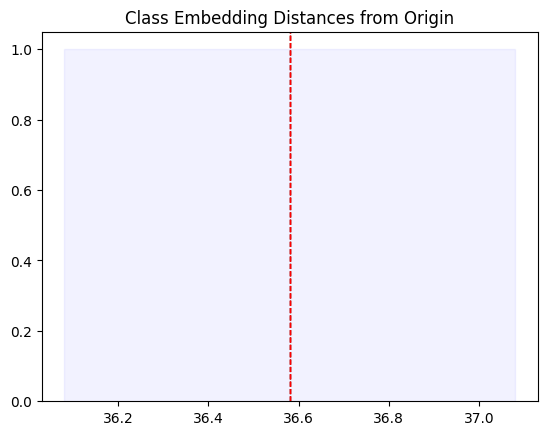

In [50]:
#Classes

computeL2Norms(class_set['embeds'])
plt.title("Class Embedding Distances from Origin")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

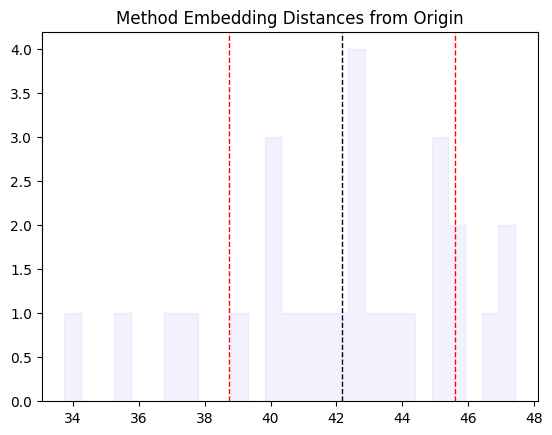

In [51]:
#Method

computeL2Norms(method_set['embeds'])
plt.title("Method Embedding Distances from Origin")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

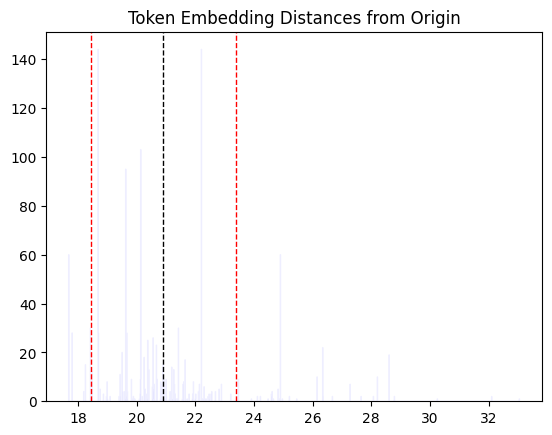

In [52]:
#Token

computeL2Norms(token_set['embeds'])
plt.title("Token Embedding Distances from Origin")
plt.show

### 2. Assess dimensionality

Correlation Matrices: finding features that are the most and least correlated

In [ ]:
def correlationMatrix(embedding_cloud,title):
    '''
    input: point cloud and granularity string(for print statement)
    output: 5 most and least correlated features printed to system

    1. calculate correlation matrix with numby
    2. find 5 maximum values in the matrix and store their indices as a tupple
    3. do the same for the minimum values
    4. print these indices along with their values as a list
    '''

  
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:
        print('Correation Matrix Analysis for ' + title + ' embeddings' )
        print()
        correlation_matrix = np.corrcoef(embedding_cloud,rowvar=False)
        corroef_to_list = []
        for i in range(len(correlation_matrix)):
            for j in range(len(correlation_matrix[i])):
                #store tuple (value, row, column)
                #do not add it if i and j are the same column
                if i != j:
                    corroef_to_list.append((correlation_matrix[i][j],i,j))
        #sort list by value
        sorted_list = sorted(corroef_to_list, key=lambda x: abs(x[0]))


        print('Top 5 most correlated features:')
        for i in range(5):
            item = sorted_list[len(sorted_list)-1-i]
            print(f"{item[1]} , {item[2]}:  {item[0]}")
        print()
        print('Top 5 least correlated features:')
        for i in range(5):
            item = sorted_list[i]
            print(f"{item[1]} , {item[2]}:  {item[0]}")



In [54]:
correlationMatrix(class_set['embeds'], 'Class')

Data not big enough!


In [55]:
correlationMatrix(method_set['embeds'], 'Method')

Correation Matrix Analysis for Method embeddings

Top 5 most correlated features:
374 , 87:  0.9305165633370506
87 , 374:  0.9305165633370505
276 , 386:  0.9217788314787886
386 , 276:  0.9217788314787885
186 , 392:  -0.9125252465687185

Top 5 least correlated features:
299 , 304:  1.933844766913908e-08
304 , 299:  1.933844766913908e-08
441 , 766:  -1.8138095494547651e-06
766 , 441:  -1.8138095494547653e-06
47 , 651:  1.8430352817597934e-06


In [56]:
correlationMatrix(token_set['embeds'], 'Token')

Correation Matrix Analysis for Token embeddings

Top 5 most correlated features:
276 , 248:  -0.8781358081808169
248 , 276:  -0.8781358081808169
739 , 682:  -0.76639429127215
682 , 739:  -0.76639429127215
739 , 692:  -0.7658769526853727

Top 5 least correlated features:
133 , 82:  -3.4446129321729453e-07
82 , 133:  -3.444612932172946e-07
300 , 647:  5.099606819073157e-07
647 , 300:  5.099606819073158e-07
9 , 217:  1.6331863027573234e-06


Scree Plot Analysis: Sorting the Eigenvalues of the correlation matrix and looking for a signifcant drop in value should give us some indication of feature importance/how many features of the 768 are important

In [ ]:
def eigenvaluePCA(embedding_cloud):
    '''
    input: point cloud
    output: matplotlib line graph

    Scree Plot Analysis:
    1.) calculate the correlation matrix
    2.) calculate eignevalues of data
    3.) sort the eigenvalues in descending order
    4.) find and plot point of inflection
    5.) plot Scree plot on line graph showing explained variance of each component
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough to perform computations!')
        return
    else:
        #correlation matrix
        correlation_matrix = np.corrcoef(embedding_cloud, rowvar=False)

        #eigenvalues of correlation matrix
        eigenvalues,eigenvectors = np.linalg.eig(correlation_matrix)
        sorted_eigenvalues = np.sort(eigenvalues)[::-1]

        #point of inflection:
        first_deriv = np.diff(sorted_eigenvalues)
        second_deriv = np.diff(first_deriv)
        inflection_index = np.argmin(second_deriv) + 1

        #fig

        fig = plt.plot(sorted_eigenvalues)
        plt.scatter(inflection_index, sorted_eigenvalues[inflection_index], color='red', s=10, zorder=3, label="Marker")
        xticks = list(plt.xticks()[0])
        xticks.remove(0)
        xticks.append(inflection_index)
        plt.xticks(xticks)
        plt.text(inflection_index+15, sorted_eigenvalues[inflection_index], 'Inflection point', fontsize=9, color='black')
        plt.xlabel('Number of Components')
        plt.ylabel('Eigenvalues of each Feature')

        return fig

Data not big enough to perform computations!


<function matplotlib.pyplot.show(close=None, block=None)>

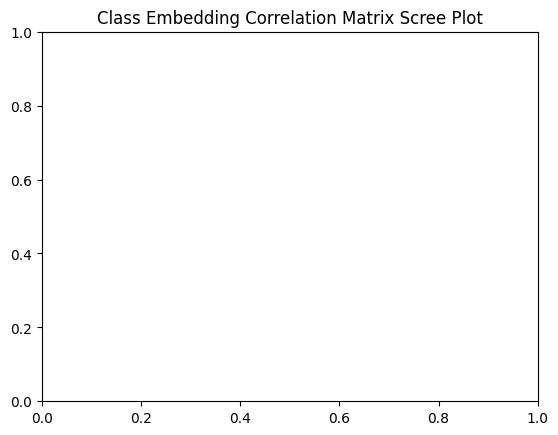

In [59]:
eigenvaluePCA(class_set['embeds'])
plt.title("Class Embedding Correlation Matrix Scree Plot")
plt.show

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<function matplotlib.pyplot.show(close=None, block=None)>

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\text.py:763: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(y))
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\text.py:906: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


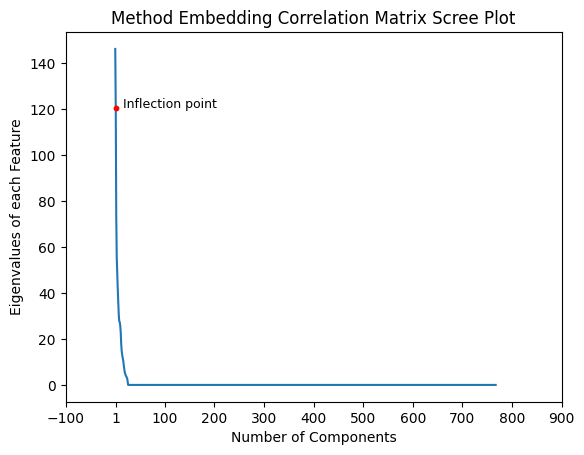

In [60]:
eigenvaluePCA(method_set['embeds'])
plt.title("Method Embedding Correlation Matrix Scree Plot")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

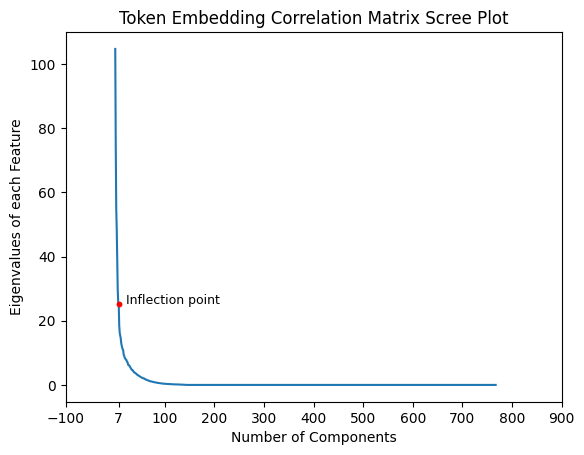

In [61]:
eigenvaluePCA(token_set['embeds'])
plt.title("Token Embedding Correlation Matrix Scree Plot")
plt.show

Principle Componenet Analysis: Use Sklearn PCA to determine feature importace/dimensionality. That is, we can find the number of components that explain P% of the variance

In [ ]:
def thresholdPCA(embedding_cloud, threshold):
    '''
    input: point cloud and float between 0 and 1
    output: matplotlib histogram 

    PCA:
    1.) standardize the data
    2.) transform data with PCA
    3.) transform explained variance ratio list to a cumulative explained variance list
    4.) Use cumulative explained variance to determine how many components account for p% of total variance
    5.) plot threshold components on a histogram with their explained variance ratios
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:

        scaler = StandardScaler()
        data_standardized = scaler.fit_transform(embedding_cloud)

        pca = PCA()
        pca.fit_transform(data_standardized)

        #returns number of components that account for p% of the total variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        threshold_components = np.argmax(cumulative_variance >= threshold) + 1
        threshold_expained_variance = pca.explained_variance_ratio_[:threshold_components]
    

        # Plot the principle components with their respective explained variance ratios
        xaxis = np.arange(1,len(threshold_expained_variance)+1)
        fig = plt.bar(xaxis,threshold_expained_variance)
    
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        return fig

Data not big enough!


<function matplotlib.pyplot.show(close=None, block=None)>

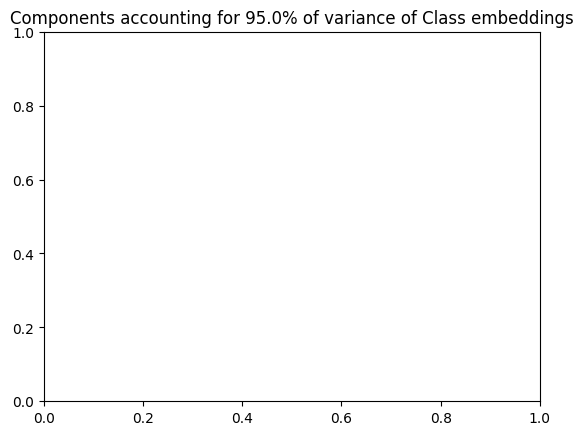

In [64]:
p = .95
thresholdPCA(class_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance of Class embeddings")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

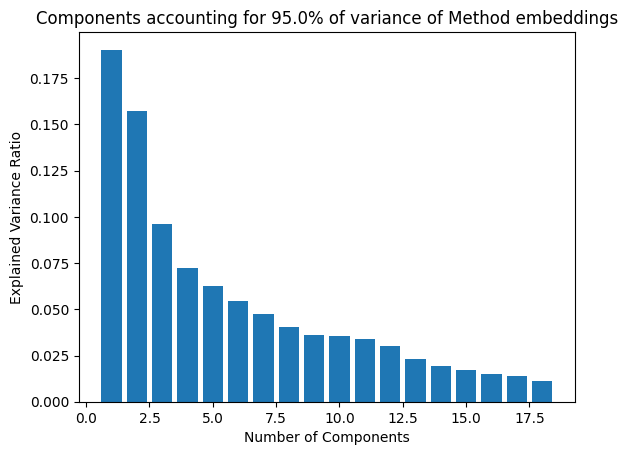

In [65]:
thresholdPCA(method_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance of Method embeddings")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

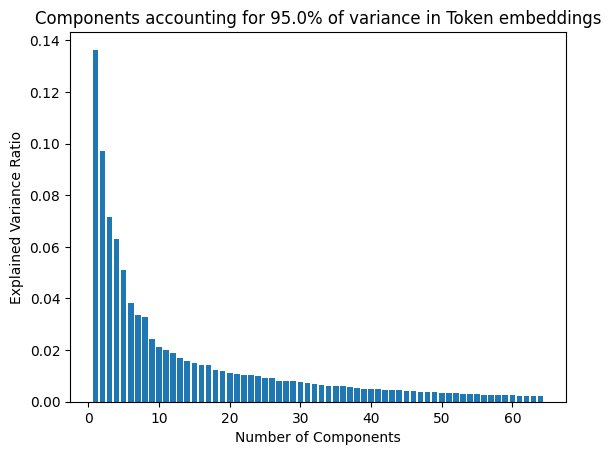

In [66]:
thresholdPCA(token_set['embeds'],p)  
plt.title(f"Components accounting for {p*100}% of variance in Token embeddings")
plt.show

### 3. Spacing/Clustering

Hierarchal Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import networkx as nx

def hierarchyClustering(embedding_cloud, title):
    '''
    input: point cloud and figure title
    output: dendrogram cluster tree representation
    
    Hierarchal Clustering Analysis
    1.) make linkage that encodes tree associated with embedding clouse
    2.) use this linkage to make a dendrogram that visualizes tree, color coding significant clusters
    '''
    if len(embedding_cloud) <= 1:
        print('Not enough data!')
    else:
        linked = linkage(embedding_cloud, method='ward')
        dendrogram(linked)
        plt.title("Hierarchy Clustering Analysis for Ivy "+title)
        plt.show()  

In [68]:
#Class
hierarchyClustering(class_set['embeds'],'Class')

Not enough data!


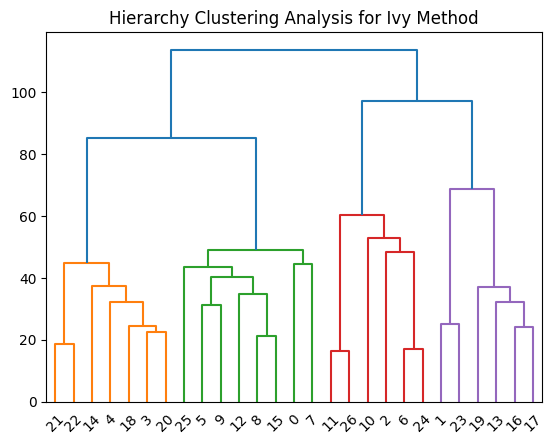

In [69]:
#Method
hierarchyClustering(method_set['embeds'],'Method')

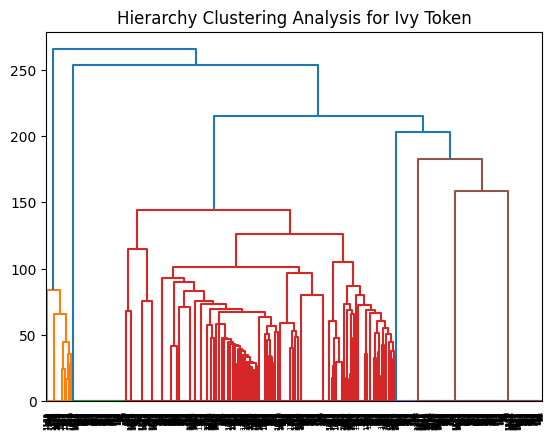

In [70]:
#Token
hierarchyClustering(token_set['embeds'],'Token')

Pairwise Distance between Embeddings

In [ ]:
def computePairwiseDistances(embedding_cloud,title):
  '''
  input: point cloud and figure title string
  output: matplotlib histogram

  Pairwise Distances (very inefficient O(n^2))
  1.) for each embedding, calculate the average distance to all other embeddings using l2-norm
  2.) add them to a list
  3.) plot the list on a histogram
  '''
  if len(embedding_cloud) <= 2:
    print('Not enough Data!')
    
  else:
    distances = []
    for i in range(len(embedding_cloud)):
      avg_distance = 0
      for j in range(len(embedding_cloud)):
        if i != j:
          distance = np.linalg.norm(np.array(embedding_cloud[i]) - np.array(embedding_cloud[j]))
          avg_distance += distance
      avg_distance /= len(embedding_cloud) - 1
      distances.append(avg_distance)
  
    avg = np.mean(distances)
    std = np.std(distances)

    plt.hist(distances, bins = round(len(embedding_cloud)/2), histtype='step', color=['blue'], fill=True, alpha=0.05)
    plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(avg+std, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(avg-std, color='red', linestyle='dashed', linewidth=1)
    plt.xlabel('Pairwise Distance')
    plt.ylabel('Frequency')
    plt.title('Ivy ' + title + ' Pairwise Distance Histogram')
    plt.show()

In [72]:
computePairwiseDistances(class_set['embeds'], 'Class')

Not enough Data!


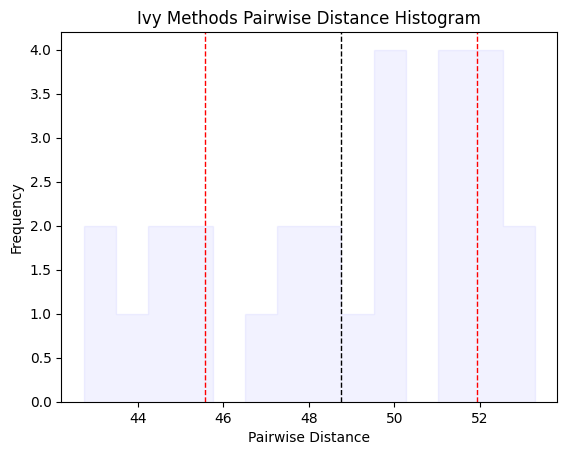

In [73]:
computePairwiseDistances(method_set['embeds'],'Methods')

Too computationally expensive to do for 300,000 tokens

### 4. Dynamism

Group embeddings based on token key word and analyze the distributions of the most commonly used tokens

In [ ]:
def tokenSorter(token_set):
    '''
    input: token dictionary
    output: new dictionary containing the distributions for the top 5 most used token names
    
    1. sort token names by most to lease common
    2. create a dictionary with top five names as keys
    3. traverse embeddings and if its corresponding name is one of the keys, append the embedding to that key
    '''
    mostFrequent, _ = map(list, zip(*Counter(token_set['names']).most_common(5)))
    tokenDict = {mostFrequent[0]:list(),mostFrequent[1]:list(),mostFrequent[2]:list(),mostFrequent[3]:list(),mostFrequent[4]:list()}
    for i in range(len(token_set['embeds'])):
        if token_set['names'][i] in mostFrequent:
            tokenDict[token_set['names'][i]].append(token_set['embeds'][i])
    return tokenDict

144


<function matplotlib.pyplot.show(close=None, block=None)>

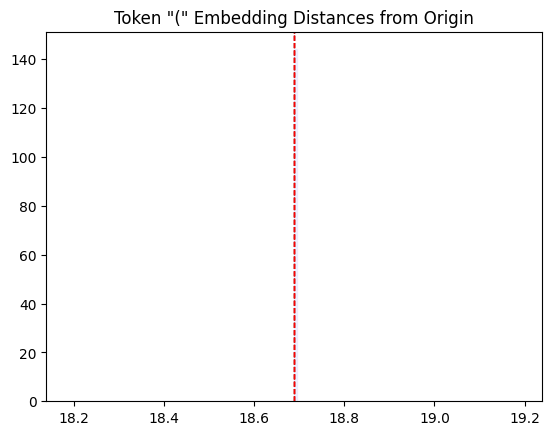

In [75]:
most_common_tokens = tokenSorter(token_set)


print(len(most_common_tokens[list(most_common_tokens.keys())[0]]))
computeL2Norms(most_common_tokens[list(most_common_tokens.keys())[0]])
plt.title("Token \"" + list(most_common_tokens.keys())[0] + "\" Embedding Distances from Origin")
plt.show

144


<function matplotlib.pyplot.show(close=None, block=None)>

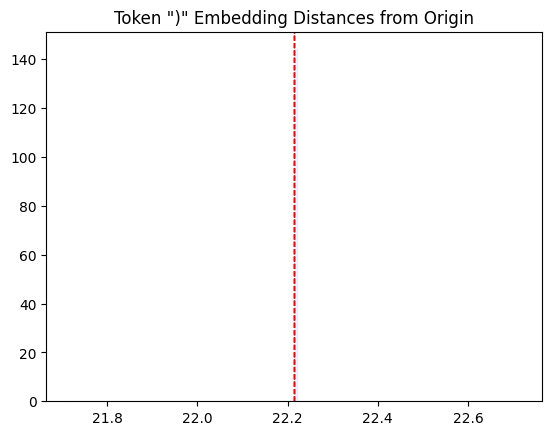

In [76]:
print(len(most_common_tokens[list(most_common_tokens.keys())[1]]))
computeL2Norms(most_common_tokens[list(most_common_tokens.keys())[1]])
plt.title("Token \"" + list(most_common_tokens.keys())[1] + "\" Embedding Distances from Origin")
plt.show

103


<function matplotlib.pyplot.show(close=None, block=None)>

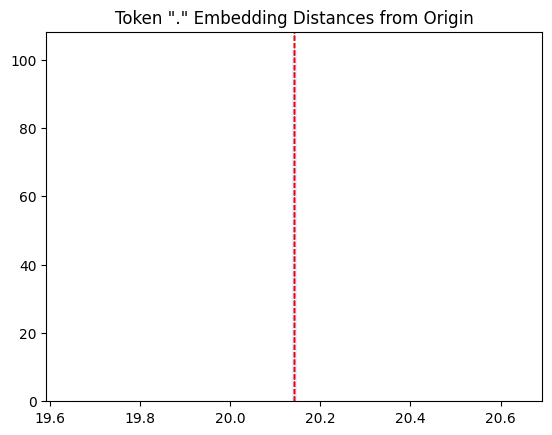

In [77]:
print(len(most_common_tokens[list(most_common_tokens.keys())[2]]))
computeL2Norms(most_common_tokens[list(most_common_tokens.keys())[2]])
plt.title("Token \"" + list(most_common_tokens.keys())[2] + "\" Embedding Distances from Origin")
plt.show

94


<function matplotlib.pyplot.show(close=None, block=None)>

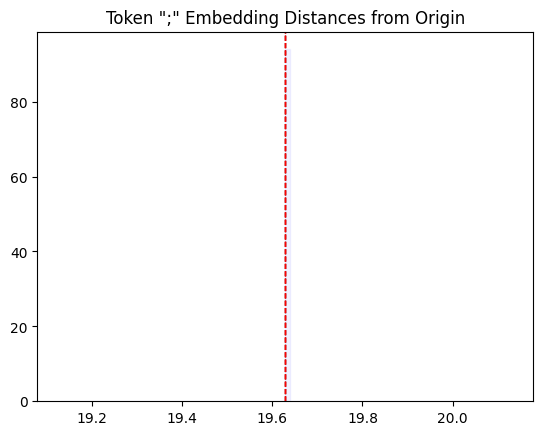

In [181]:
print(len(most_common_tokens[list(most_common_tokens.keys())[3]]))
computeL2Norms(most_common_tokens[list(most_common_tokens.keys())[3]])
plt.title("Token \"" + list(most_common_tokens.keys())[3] + "\" Embedding Distances from Origin")
plt.show

60


<function matplotlib.pyplot.show(close=None, block=None)>

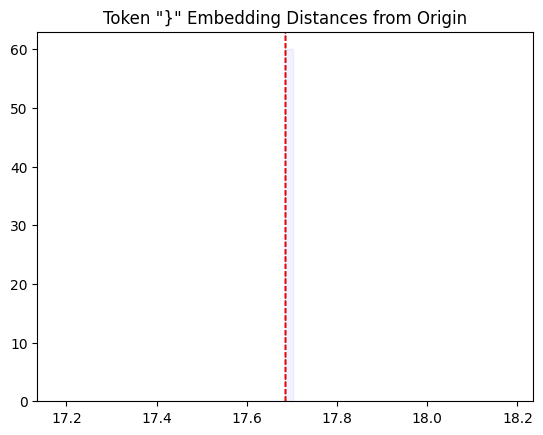

In [78]:
print(len(most_common_tokens[list(most_common_tokens.keys())[4]]))
computeL2Norms(most_common_tokens[list(most_common_tokens.keys())[4]])
plt.title("Token \"" + list(most_common_tokens.keys())[4] + "\" Embedding Distances from Origin")
plt.show

### Data Visualization/Outlier Detection

Principle Component Analysis: use PCA to tranform data to lower dimensionality then graph it on a scatter plot. Then use reverse transform to detect outliers from PCA

In [ ]:
def visualPCA(set, title):
    '''
    input: class, method, or token dictionary created by cynthia's helper function path_to_data()
    output: matplot lib scatter representing a pca on the point cloud and a list of all the outliers detected outputed to system print

    Visual PCA
    1. standardize data
    2. use sklearn PCA to fit and transform data
    3. plot PCA on a scatterplot
    4. inverse transform the PCA-transformed data
    5. take the difference between the data and transformed data
    6. indices with biggest differences (transformed the most by the PCA) are considered outliers
    '''
    if len(set['embeds']) <= 1:
        print("Data not big enough")
    else:
        scaler = StandardScaler()
        data_standardized = scaler.fit_transform(set['embeds'])

        pca = PCA(n_components=2)
        principle_components = pca.fit_transform(data_standardized)

        plt.scatter(principle_components[:, 0], principle_components[:, 1], alpha=0.7)
        plt.title('PCA Visualization for Ivy'+title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True)
        plt.show()


        # Reconstruct the data
        pca_reconstructed = pca.inverse_transform(principle_components)
    
        # Calculate the reconstruction error for each data point
        errors = np.linalg.norm(data_standardized - pca_reconstructed, axis=1)
    
        # Detect outliers based on reconstruction error (thresholding)
        # Outliers are those with error significantly higher than the mean
        avg_error = np.mean(errors)
        std_error = np.std(errors)
    
        outlier_indices = np.where(errors > avg_error + 2 * std_error)[0]

        print('List of Outliers:')
        for outlier in outlier_indices:
            print(set['names'][outlier])

In [87]:
outliers = visualPCA(class_set,'Class')



Data not big enough


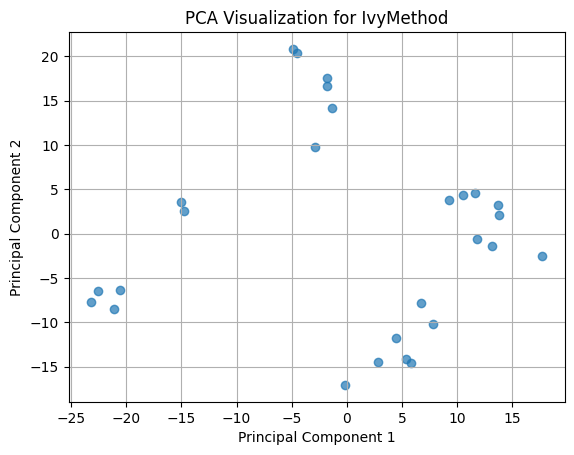

List of Outliers:


In [88]:
visualPCA(method_set,'Method')

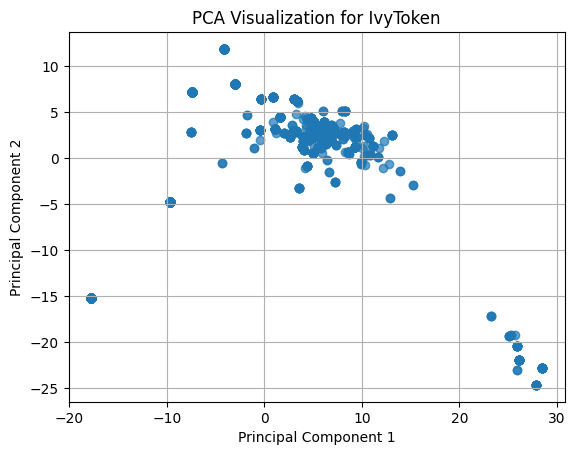

List of Outliers:
checkInterrupted
checkInterrupted
CircularDependencyStrategy
getCircularDependencyStrategy
getCircularDependencyStrategy
getOperatingThread
operatingThread
WeakReference
WeakReference
peekInContextStack
Cannot top from non List object 
Cannot pop from non List object 
Cannot pop from non List object 
pushNewCopyContext
Cannot push to non List object 
WeakReference
operatingThread
WeakReference
operatingThread
operatingThread
WeakReference
WeakReference
operatingThread
CircularDependencyStrategy
WeakReference


In [91]:
visualPCA(token_set,'Token')

UMAP: Non Linear dimensionality reduction tool that is good at preserving global structure and identifying clusters

In [ ]:
import umap

def visualUMAP(embedding_cloud,title):
    '''
    input: point cloud and figure title
    output: matplotlib scatterplot
    
    UMAP
    1. declare a umap with 2 components and random state at 42
    2. transform the data with the umap
    3. plot the transformed data on a scatterplot using matplotlib
    '''
    if len(embedding_cloud) <= 1:
        print('Data not big enough!')
    else:
        reducer = umap.UMAP(n_components=2, random_state=42)
        umap_result = reducer.fit_transform(embedding_cloud)
        plt.scatter(umap_result[:, 0], umap_result[:, 1])
        plt.title("UMAP Visualization for Ivy " + title )
        plt.show()

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [325]:
visualUMAP(class_set['embeds'],'Class')

Data not big enough!


c:\Users\gbrow\Code\python\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


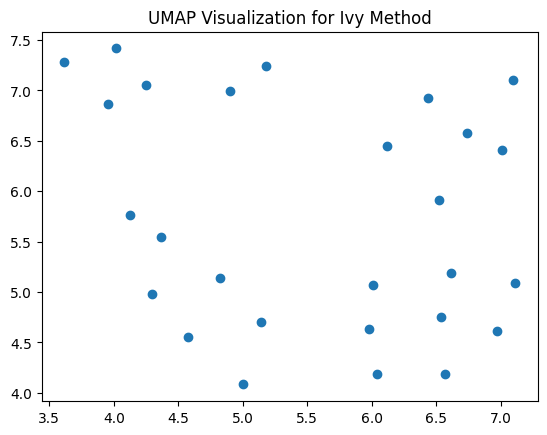

In [326]:
visualUMAP(method_set['embeds'],'Method')

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


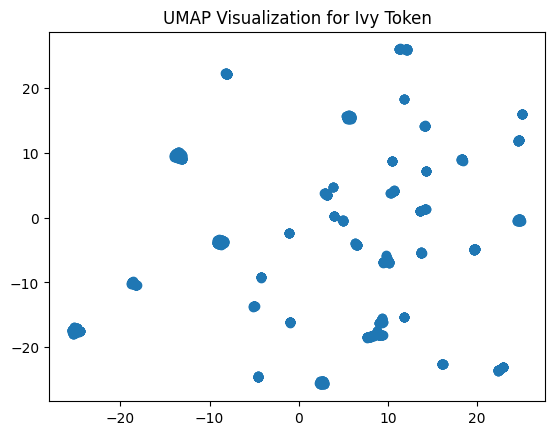

In [327]:
visualUMAP(token_set['embeds'],'Token')